In [1]:
# !pip install torch==1.10.2+cu113  torchvision==0.11.3+cu113  -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import os
import tqdm
import numpy as np

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport utils_data
%aimport utils_model
%aimport utils_attack

In [3]:
torch.__version__

'1.10.2+cu113'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Datasets and dataloaders preparation 

In [5]:
(train_set_10, test_set_10), (train_loader_10, test_loader_10) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar10', 
    root_data_folder='./data', 
    batch_size=64
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
(train_set_100, test_set_100), (train_loader_100, test_loader_100) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar100', 
    root_data_folder='./data', 
    batch_size=64
)

Files already downloaded and verified
Files already downloaded and verified


# Model

## Loading and fine-tuning ResNet50 pretrained on ImageNet 
**(you can skip this part if you already have a model pretrained on CIFAR10/100)**

In [7]:
# model_10 = torchvision.models.resnet50(pretrained=True)
# model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
# model_10 = model_10.to(device)
# model_10

In [8]:
# model_100 = torchvision.models.resnet50(pretrained=True)
# model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
# model_100 = model_100.to(device)
# model_100

In [9]:
# utils_data.set_random_seeds(seed_value=123, device=device)
# criterion = nn.CrossEntropyLoss()

# '''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
# optimizer_10 = optim.SGD(model_10.parameters(), lr=1e-3,
#                       momentum=0.9, weight_decay=5e-4)
# scheduler_10 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_10, T_max=200)

In [10]:
# utils_data.set_random_seeds(seed_value=123, device=device)
# criterion = nn.CrossEntropyLoss()

# optimizer_100 = optim.SGD(model_100.parameters(), lr=1e-3,
#                       momentum=0.9, weight_decay=5e-4)
# scheduler_100 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_100, T_max=200)

In [11]:
# model_10 = utils_model.train(train_loader_10, test_loader_10, model_10, criterion, optimizer_10, scheduler_10, n_epochs=10, device=device)

In [12]:
# model_100 = utils_model.train(train_loader_100, test_loader_100, model_100, criterion, optimizer_100, scheduler_100, n_epochs=10, device=device)

In [13]:
# path_to_model_save = './models'
# torch.save(model_10.state_dict(), os.path.join(path_to_model_save, 'cifar10.pt'))

In [14]:
# path_to_model_save = './models'
# torch.save(model_100.state_dict(), os.path.join(path_to_model_save, 'cifar100.pt'))

## Load a model pretrained on CIFAR10/100
**to load pretrained model uncomment the cell below**

In [15]:
path_to_model_save = './models'
model_10 = torchvision.models.resnet50(pretrained=True)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10.load_state_dict(
    torch.load(
        os.path.join(path_to_model_save, 'cifar10.pt'), map_location=device
    )
)
model_10 = model_10.to(device)

In [16]:
path_to_model_save = './models'
model_100 = torchvision.models.resnet50(pretrained=True)
model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
model_100.load_state_dict(
    torch.load(
        os.path.join(path_to_model_save, 'cifar100.pt'), map_location=device
    )
)
model_100 = model_100.to(device)

In [17]:
utils_data.set_random_seeds(seed_value=123, device=device)

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
# optimizer = optim.SGD(model.parameters(), lr=1e-3,
#                       momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = nn.CrossEntropyLoss()

# FGSM attack

We will attack only correct classified examples

In [18]:
def get_only_correct_classified_examples(dataloader, clf, batch_size=64, device='cpu'):
    correct_images, correct_labels = torch.tensor([], device=device), torch.tensor([], device=device)
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        preds = clf(images)
        _, output_tag = torch.max(preds, dim=1) 
        correct_images = torch.cat([correct_images, images[output_tag == labels]], dim=0)
        correct_labels = torch.cat([correct_labels, labels[output_tag == labels]], dim=0)
        #correct_labels = torch.cat([correct_labels, labels[output_tag == labels].float()], dim=0)

    correct_dataset = torch.utils.data.TensorDataset(correct_images, correct_labels)
    
    return correct_dataset, torch.utils.data.DataLoader(
            correct_dataset, batch_size=batch_size,
            shuffle=False, num_workers=0
        )

In [19]:
test_set_10, test_loader_10 = get_only_correct_classified_examples(test_loader_10, model_10, device=device)
test_set_100, test_loader_100 = get_only_correct_classified_examples(test_loader_100, model_100, device=device)

In [20]:
cnt_10 = sum([1 for _ in test_set_10])
cnt_100 = sum([1 for _ in test_set_100])
cnt_10, cnt_100

(8463, 5897)

In [21]:
results_df_10 = utils_attack.test_robustness_simple(
    model_10,
    test_loader_10,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df_10

100%|██████████| 20/20 [04:09<00:00, 12.46s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.961361
0.001438,0.956280
0.002069,0.947182
0.002976,0.937020
0.004281,0.917641
0.006158,0.880066
0.008859,0.831029
0.012743,0.762732
0.018330,0.668439


In [22]:
results_df_100 = utils_attack.test_robustness_simple(
    model_100,
    test_loader_100,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df_100

100%|██████████| 20/20 [02:59<00:00,  8.98s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.914702
0.001438,0.904528
0.002069,0.890283
0.002976,0.871799
0.004281,0.836527
0.006158,0.784467
0.008859,0.719858
0.012743,0.637443
0.018330,0.532983


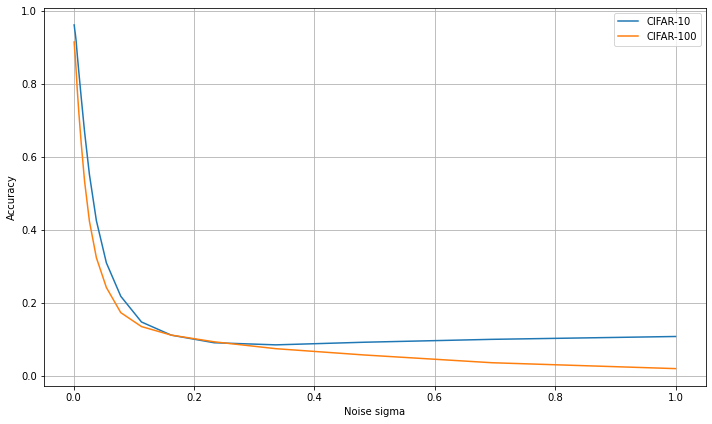

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(results_df_10.index, results_df_10['Accuracy'], label='CIFAR-10')
ax.plot(results_df_100.index, results_df_100['Accuracy'], label='CIFAR-100')
ax.set_xlabel('Noise sigma')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()

In [24]:
all_preds_10, all_preds_100 = torch.tensor([], device=device), torch.tensor([], device=device)
all_labels_10, all_labels_100 =  torch.tensor([], device=device), torch.tensor([], device=device)
# for images, labels in tqdm(test_loader_10):
for images, labels in test_loader_10:
    images, labels = images.to(device), labels.to(device)
    pred_10 = model_10(images)
    all_preds_10 = torch.cat([all_preds_10, pred_10.argmax(axis=1)])
    all_labels_10 = torch.cat([all_labels_10, labels])
    
# for images, labels in tqdm(test_loader_100):
for images, labels in test_loader_100:
    images, labels = images.to(device), labels.to(device)
    pred_100 = model_100(images)
    all_preds_100 = torch.cat([all_preds_100, pred_100.argmax(axis=1)])
    all_labels_100 = torch.cat([all_labels_100, labels])
    
acc_10 = accuracy_score(all_labels_10.detach().cpu().numpy(), all_preds_10.detach().cpu().numpy())
acc_100 = accuracy_score(all_labels_100.detach().cpu().numpy(), all_preds_100.detach().cpu().numpy())
acc_10, acc_100

(0.9741226515420064, 0.9340342547057826)

In [25]:
all_preds_10_np = all_preds_10.detach().cpu().numpy()
all_preds_100_np = all_preds_100.detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


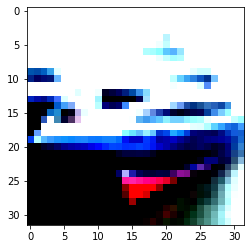

In [46]:
img, l = test_set_10[1]
print(img.shape)
plt.imshow(
    np.transpose(img.detach().cpu().numpy(),[1,2,0])
)
# plt.imshow(img.detach().cpu().numpy().reshape(32, 32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


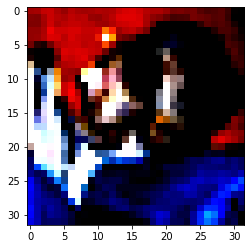

In [48]:
img, l = next(iter(test_loader_10))
print(img.shape)
plt.imshow(
    np.transpose(img[0].detach().cpu().numpy(),[1,2,0])
)

In [ ]:
preds_class_change_10, radii_class_change_10 = utils_attack.get_adversarial_radii(
    model_10,
    all_preds_10_np,
    dataloader=test_loader_10,
    loss=criterion,
    num_samples=cnt_10,
    min_v=1e-3,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
)

preds_class_change_100, radii_class_change_100 = utils_attack.get_adversarial_radii(
    model_100,
    all_preds_100_np,
    dataloader=test_loader_100,
    loss=criterion,
    num_samples=cnt_100,
    min_v=1e-3,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# preds_class_change_10, radii_class_change_10 = utils_attack.get_adversarial_radii(
#     model_10,
#     all_preds_10_np,
#     dataloader=test_loader_10,
#     loss=criterion,
#     num_samples=cnt_10,
#     min_v=1e-4,
#     max_v=10,
#     step_v=2 ** 0.5,
#     method="pgd",
#     device=device,
# )

# preds_class_change_100, radii_class_change_100 = utils_attack.get_adversarial_radii(
#     model_100,
#     all_preds_100_np,
#     dataloader=test_loader_100,
#     loss=criterion,
#     num_samples=cnt_100,
#     min_v=1e-4,
#     max_v=10,
#     step_v=2 ** 0.5,
#     method="pgd",
#     device=device,
# )

In [ ]:
# finite_radii_class_change_mask.shape, radii_inv_class_change.shape, finite_radii_class_change_mask.sum()

In [ ]:
radii_inv_class_change_10, radii_inv_class_change_100 = -radii_class_change_10, -radii_class_change_100
# radii_inv_class_change_10, radii_inv_class_change_100 = 1. / radii_class_change_10, 1. / radii_class_change_100
finite_radii_class_change_mask_10, finite_radii_class_change_mask_100 = radii_inv_class_change_10 != -np.inf, radii_inv_class_change_100 != -np.inf
radii_inv_class_change_finite_10, radii_inv_class_change_finite_100 = radii_inv_class_change_10[finite_radii_class_change_mask_10], radii_inv_class_change_100[finite_radii_class_change_mask_100]
preds_class_change_10, preds_class_change_100 = all_preds_10_np[finite_radii_class_change_mask_10], all_preds_100_np[finite_radii_class_change_mask_100]

In [ ]:
radii_class_change_finite_10, radii_class_change_finite_100 = radii_class_change_10[finite_radii_class_change_mask_10], radii_class_change_100[finite_radii_class_change_mask_100]

In [ ]:
finite_radii_class_change_mask_10.mean(), finite_radii_class_change_mask_100.mean()

In [ ]:
min_eps = 1e-4
max_eps = 1e3
step_eps = 2 ** 0.5
num_eps = int((np.log10(max_eps) - np.log10(min_eps)) / np.log10(step_eps)) + 1
bins = list(np.geomspace(min_eps, max_eps, num_eps))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].hist(radii_class_change_finite_10, bins=bins);
ax[0].set_title('CIFAR-10')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].hist(radii_class_change_finite_100, bins=bins);
ax[1].set_title('CIFAR-100')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.hist(radii_class_change_finite_10, bins=bins, label='CIFAR-10', alpha=0.5);
ax.hist(radii_class_change_finite_100, bins=bins, label='CIFAR-100', alpha=0.5);
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right');

In [ ]:
from functools import partial

def get_radii_preds_func(radii, preds):
    return preds, radii

get_radii_inv_partial_class_change_10 = partial(get_radii_preds_func, radii_inv_class_change_10)
get_radii_inv_partial_class_change_100 = partial(get_radii_preds_func, radii_inv_class_change_100)

In [ ]:
rejection_rates = np.linspace(0, 1.0, 20)

radii_accs_class_change_10 = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change_10,
    all_preds_10_np,
    all_labels_10.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)
radii_accs_class_change_100 = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change_100,
    all_preds_100_np,
    all_labels_100.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

perf_metrics = [radii_accs_class_change_10, radii_accs_class_change_100]
line_labels = ['CIFAR-10', 'CIFAR-100']

for metric, label in zip(perf_metrics, line_labels):
    ax.plot(rejection_rates[0:len(metric)], metric, label=label)
ax.set_xlabel('Rejection rate')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
pentropy_accs_10 = utils_attack.reject_by_metric(
    utils_attack.get_ensemble_predictive_entropy,
    all_preds_10_np,
    all_labels_10.detach().cpu().numpy(), 
    rejection_rates,
    accuracy_score
)
pentropy_accs_100 = utils_attack.reject_by_metric(
    utils_attack.get_ensemble_predictive_entropy,
    all_preds_100_np,
    all_labels_100.detach().cpu().numpy(), 
    rejection_rates,
    accuracy_score
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(rejection_rates[0:len(pentropy_accs_10)], pentropy_accs_10, label='CIFAR-10')
ax[0].set_xlabel('Rejection rate')
ax[0].set_ylabel('Accuracy')
ax[0].grid(visible=True)
ax[0].legend()

ax[1].plot(rejection_rates[0:len(pentropy_accs_100)], pentropy_accs_100, label='CIFAR-100')
ax[1].set_xlabel('Rejection rate')
ax[1].set_ylabel('Accuracy')
ax[1].grid(visible=True)
ax[1].legend()

plt.tight_layout()
plt.show()